In [1]:
import os
import time
import glob
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2

from PIL import Image
from keras import backend as K

In [2]:
ship_dir = '/kaggle/input/airbus-ship-detection'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

In [3]:
masks = pd.read_csv(os.path.join(ship_dir + '/train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')

masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
masks.drop(['ships'], axis=1, inplace=True)
print(unique_img_ids.loc[unique_img_ids.ships>=2].head())

81723 masks in 42556 images
150000 empty images in 192556 total images
          ImageId  ships  has_ship
3   000194a2d.jpg      5       1.0
5   00021ddc3.jpg      9       1.0
6   0002756f7.jpg      2       1.0
11  000532683.jpg      2       1.0
15  0005d01c8.jpg      2       1.0


160 masks


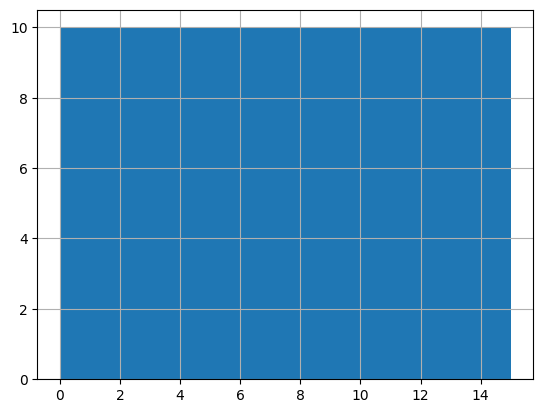

In [4]:
SAMPLES_PER_GROUP = 10
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [5]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

968 training masks
242 validation masks


In [6]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [171]:
def load_images(image, folder):
    if folder == "train":
        path = train_image_dir + '/' + image
    else:
        path = test_image_dir + '/' + image
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    return image

In [9]:
images_pixels = []
masks_pixels = []

images = train_df.groupby('ImageId')
for image_id, group_data in images:
    pixels = np.zeros((768, 768))
    for index, value in group_data['EncodedPixels'].items():
        if isinstance(value, str):
            pixels += rle_decode(value)
            
    images_pixels.append(load_images(image_id, "train"))
    masks_pixels.append(pixels)

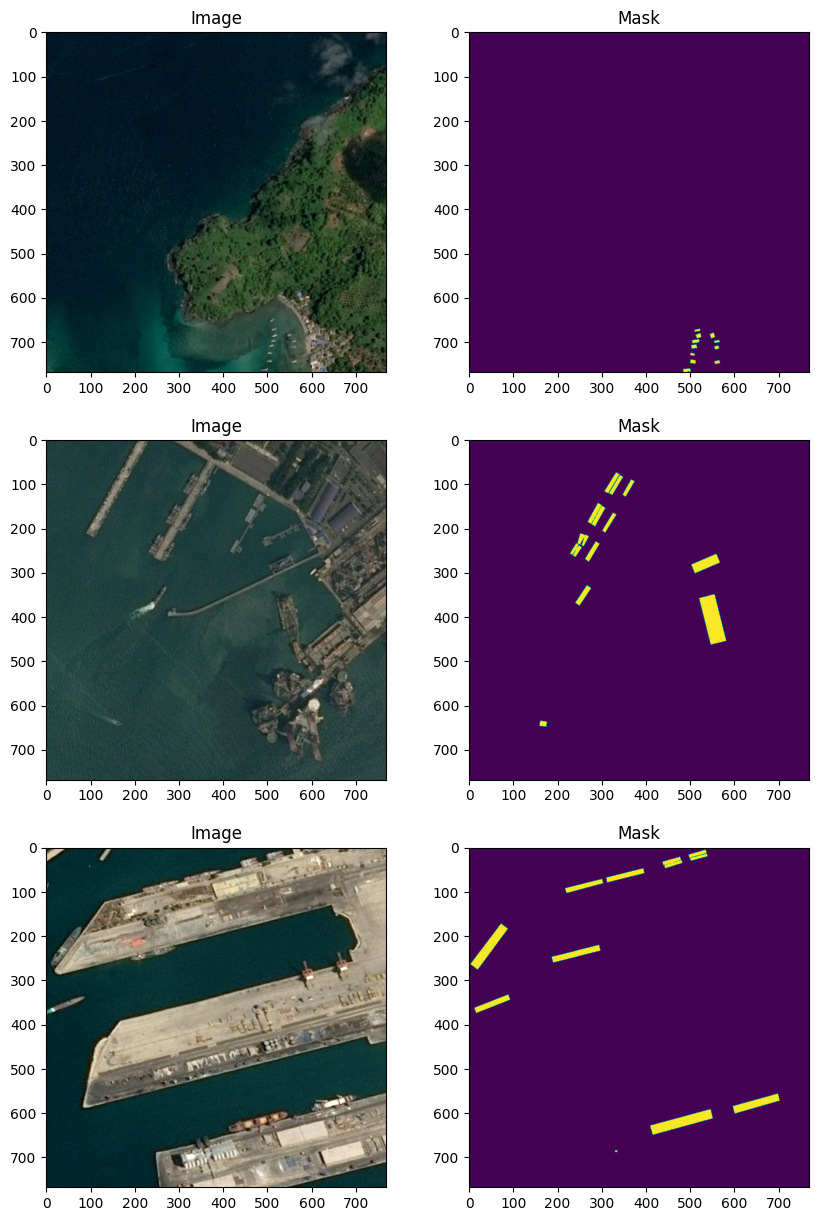

In [10]:
fig = plt.figure(figsize=(10, 15))
fig.add_subplot(3, 2, 1)
plt.imshow(images_pixels[99]*255)
plt.title("Image")
fig.add_subplot(3, 2, 2)
plt.imshow(masks_pixels[99])
plt.title("Mask")
fig.add_subplot(3, 2, 3)
plt.imshow(images_pixels[100]*255)
plt.title("Image")
fig.add_subplot(3, 2, 4)
plt.imshow(masks_pixels[100])
plt.title("Mask")
fig.add_subplot(3, 2, 5)
plt.imshow(images_pixels[101]*255)
plt.title("Image")
fig.add_subplot(3, 2, 6)
plt.imshow(masks_pixels[101])
plt.title("Mask")
plt.show()

In [11]:
def input_layer():
    return tf.keras.layers.Input(shape=(768, 768) + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(1, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

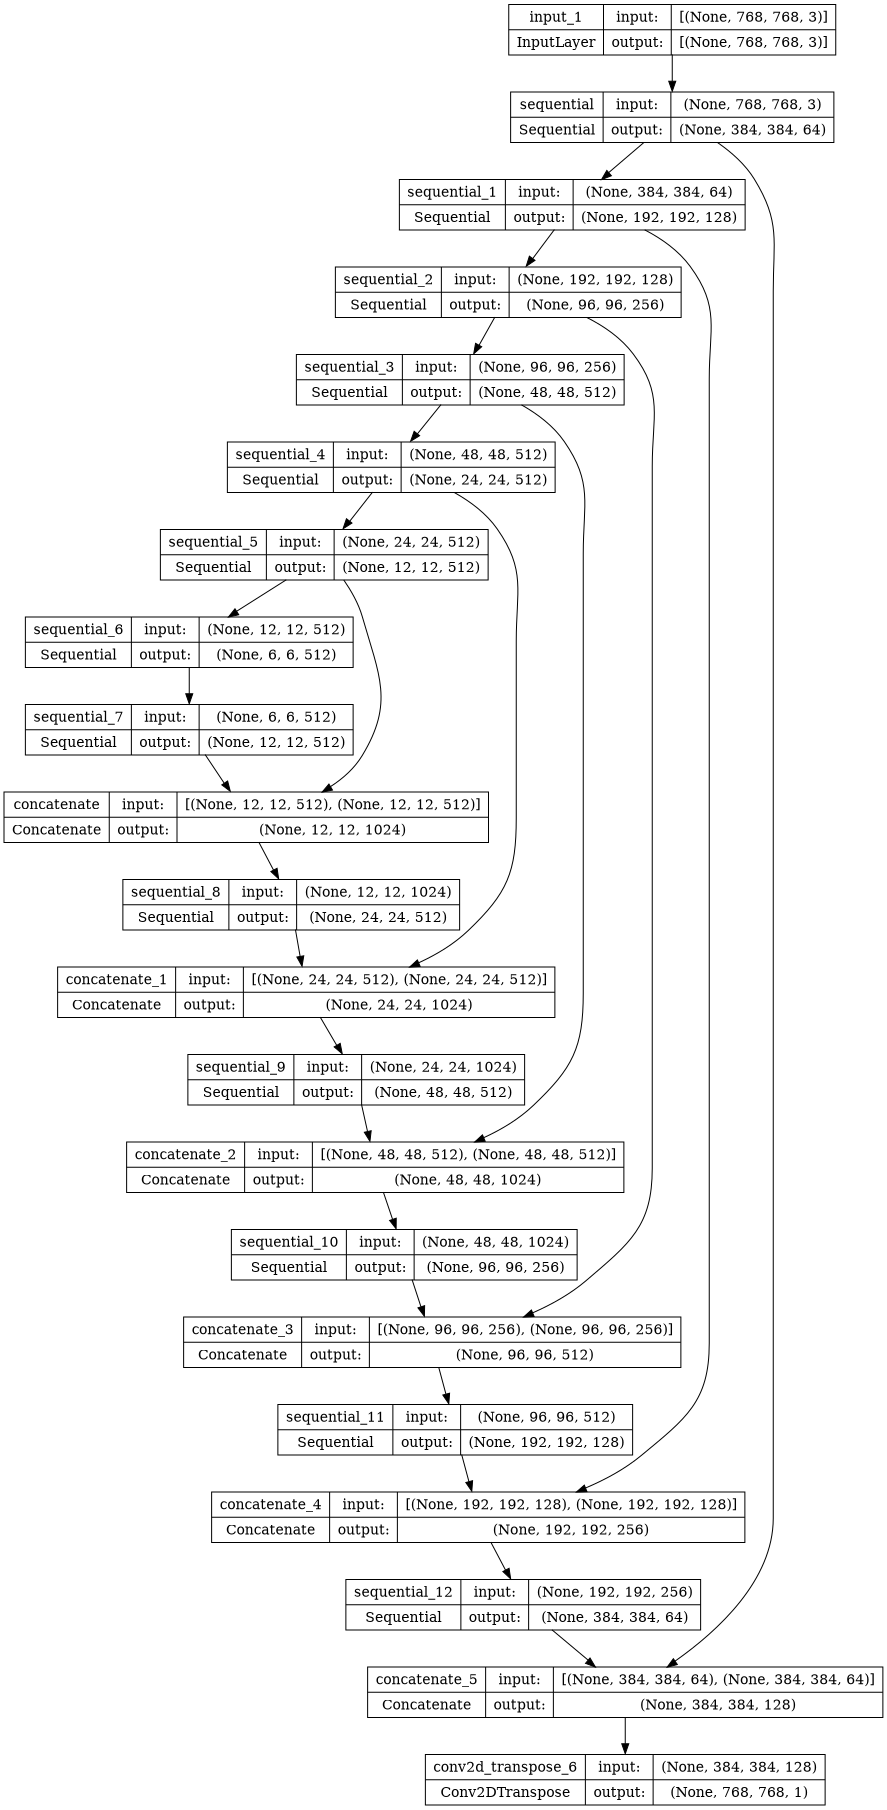

In [12]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
    
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

In [15]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    loss = (1 - jac) * smooth
    return loss

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

In [16]:
unet_like.compile(optimizer='adam', loss=[jaccard_distance_loss], metrics=[dice_coef])

In [17]:
unet_like.fit(tf.convert_to_tensor(images_pixels), tf.convert_to_tensor(masks_pixels), epochs=10, batch_size=16)

Epoch 1/10
8/8 [==============================] - 505s 62s/step - loss: 76.2934 - dice_coef: 0.0327
Epoch 2/10
8/8 [==============================] - 528s 65s/step - loss: 63.8401 - dice_coef: 0.0669
Epoch 3/10
8/8 [==============================] - 514s 65s/step - loss: 44.7121 - dice_coef: 0.1854
Epoch 4/10
8/8 [==============================] - 497s 62s/step - loss: 24.6812 - dice_coef: 0.4439
Epoch 5/10
8/8 [==============================] - 501s 63s/step - loss: 12.0109 - dice_coef: 0.7028
Epoch 6/10
8/8 [==============================] - 499s 62s/step - loss: 7.2648 - dice_coef: 0.7944
Epoch 7/10
8/8 [==============================] - 511s 64s/step - loss: 5.6714 - dice_coef: 0.8100
Epoch 8/10
8/8 [==============================] - 504s 63s/step - loss: 5.0572 - dice_coef: 0.8132
Epoch 9/10
8/8 [==============================] - 499s 62s/step - loss: 4.7737 - dice_coef: 0.8145
Epoch 10/10
8/8 [==============================] - 498s 62s/step - loss: 4.6065 - dice_coef: 0.8150


In [161]:
unet_like.save('unet_like.keras')

In [19]:
# unet_like = keras.models.load_model('/kaggle/working/unet_like.keras')

In [172]:
test_images_pixels = []
test_images_name = os.listdir(test_image_dir)[10:12]

for image_name in test_images_name:
    test_images_pixels.append(load_images(image_name, "test"))
    
test_images_tensor = tf.convert_to_tensor(test_images_pixels)

In [173]:
pred = unet_like.predict(test_images_tensor)
pred = np.squeeze(pred)

1/1 [==============================] - 3s 3s/step


In [175]:
pred = np.where(pred < 0.02, 0.0, 1.0)

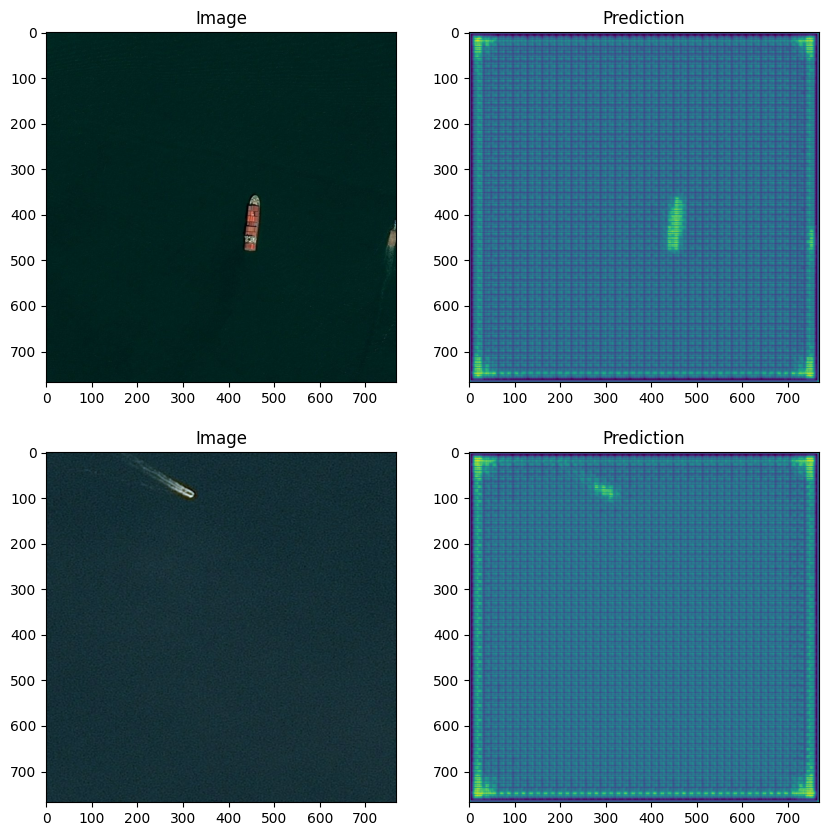

In [177]:
blur0 = cv2.GaussianBlur(pred[0], (7,7), cv2.BORDER_DEFAULT)
blur1 = cv2.GaussianBlur(pred[1], (7,7), cv2.BORDER_DEFAULT)

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(2, 2, 1)
plt.imshow(test_images_pixels[0]*255)
plt.title("Image")
fig.add_subplot(2, 2, 2)
plt.imshow(blur0)
plt.title("Prediction")
fig.add_subplot(2, 2, 3)
plt.imshow(test_images_pixels[1]*255)
plt.title("Image")
fig.add_subplot(2, 2, 4)
plt.imshow(blur1)
plt.title("Prediction")
plt.show()